In [1]:
import os

import torch
import torch.nn as nn

import pickle as pk

from transformer_definitions import AuTransformer
from torch.utils.data import Dataset, DataLoader

MODEL_NAME = "trained_model.pk"
DATA_PATH = "problem_1_train_dfa.dat"

# Model and data definitions

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        #self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        
        #div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        div_term = 10000 ** ( (2 * torch.arange(0, d_model) ) / d_model)
        pe = torch.zeros(max_len, 1, d_model)
        for i in range(max_len):
            if i % 2 == 0:    
                pe[i, 0, :] = torch.sin(position[i] / div_term)
            else:
                pe[i, 0, :] = torch.cos(position[i] / div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return x #self.dropout(x)


# sidenote: understanding skip-connections: https://theaisummer.com/skip-connections/
class Encoder(nn.Module):
    def __init__(self, alphabet_size: int, embedding_dim: int, max_len:int, embedding_layer=None):
        super().__init__()
        self.pos_encoding = PositionalEncoding(d_model=embedding_dim, max_len=max_len+2)
        
        self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=3)
        self.ln = nn.LayerNorm(embedding_dim, eps=1e-12, elementwise_affine=True)
        
    def forward(self, x: torch.Tensor):
        sequence_len = list(x.size())[0]
        x = self.pos_encoding(x)
        
        attn_output, attn_output_weights = self.mha(query=x, key=x, value=x, is_causal=True, \
                                                attn_mask=nn.Transformer.generate_square_subsequent_mask(sequence_len))

        x = x + attn_output # skip-connection
        x = self.ln(x)
                
        return x, attn_output, attn_output_weights
    
class Decoder(nn.Module):
    def __init__(self, alphabet_size: int, embedding_dim: int, max_len:int, embedding_layer=None): #must be same as encoder
        super().__init__()
        self.pos_encoding = PositionalEncoding(d_model=embedding_dim, max_len=max_len+2)
        
        self.masked_mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=3)
        self.ln = nn.LayerNorm(embedding_dim, eps=1e-12, elementwise_affine=True)

        self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=3)
        
        
    def forward(self, x: torch.Tensor, query: torch.Tensor=None, key: torch.Tensor=None):
        sequence_len = list(x.size())[0]
        x = self.pos_encoding(x)
        
        attn_output, attn_output_weights = self.masked_mha(query=x, key=x, value=x, is_causal=True, \
                                                attn_mask=nn.Transformer.generate_square_subsequent_mask(sequence_len))#, is_causal=True)

        x = x + attn_output # skip-connection
        x = self.ln(x)
        
        if query is None or key is None: # only for debugging
            attn_output, attn_output_weights = self.mha(query=x, key=x, value=x)
        else:
            attn_output, attn_output_weights = self.mha(query=query, key=key, value=x)
        
        x = x + attn_output # skip-connection
        x = self.ln(x)
        
        return x
    
# sidenote: understanding skip-connections: https://theaisummer.com/skip-connections/
class AuTransformer(nn.Module):
    def __init__(self, alphabet_size: int, embedding_dim: int, max_len:int):
        super().__init__()
        
        self.input_embedding = nn.Embedding(alphabet_size+3, embedding_dim) # +3 for start, stop, padding symbol
        self.encoder = Encoder(alphabet_size=alphabet_size, embedding_dim=embedding_dim, max_len=max_len, embedding_layer=self.input_embedding)
        self.decoder = Decoder(alphabet_size=alphabet_size, embedding_dim=embedding_dim, max_len=max_len, embedding_layer=self.input_embedding)
        
        self.output_fnn = nn.Linear(in_features=embedding_dim, out_features=alphabet_size+3) # +2 for start and stop
        self.gelu = torch.nn.GELU()
        
        self.dropout = nn.Dropout(0.2)
        self.softmax_output = nn.Softmax(dim=-1)
        
        self.attention_output_layer = nn.Identity() 
        self.attention_weight_layer = nn.Identity() 
        self.src_embedding_output_layer = nn.Identity() 
        self.tgt_embedding_output_layer = nn.Identity() 

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        src_embedding = self.input_embedding(src)
        src_embedding_out = self.src_embedding_output_layer(src_embedding)

        x, attention_output, attention_weights = self.encoder(src_embedding)
        x = self.dropout(x)

        attention_output = self.attention_output_layer(attention_output)
        attention_weights = self.attention_weight_layer(attention_weights)
        
        tgt_embedding = self.input_embedding(tgt)
        tgt_embedding_out = self.tgt_embedding_output_layer(tgt_embedding) 

        x = self.decoder(x=tgt_embedding, query=x, key=x)
        x = self.dropout(x)
        
        x = self.gelu(self.output_fnn(x))
        x = self.softmax_output(x)
        return x

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, datapath: str, maxlen: int, pad_sequences: bool=True, max_sequences: int=None):
        super().__init__()
        
        assert(os.path.isfile(datapath))
        self.symbol_dict = dict()
        self.label_dict = dict()
        self.sequences, self.labels, self.sequence_lengths = self._read_sequences(datapath, max_sequences)
        print("Sequences loaded. Some examples: \n{}".format(self.sequences[:3]))
        
        self.SOS = self.alphabet_size
        self.EOS = self.alphabet_size + 1
        self.PAD = self.alphabet_size + 2
        self.maxlen = maxlen + 2  # +2 for EOS/PAD and SOS 
        self.pad_sequences = pad_sequences
        
    def encode_sequences(self):
        self.ordinal_seq, self.ordinal_seq_sr = self._ordinal_encode_sequences(self.sequences)
        self.one_hot_seq, self.one_hot_seq_sr = self._one_hot_encode_sequences(self.sequences)
        
        del self.sequences
        self.sequences = None
        
        print("The symbol dictionary: {}".format(self.symbol_dict))
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.ordinal_seq[idx], self.ordinal_seq_sr[idx], self.one_hot_seq[idx], \
               self.one_hot_seq_sr[idx], self.labels[idx], self.sequence_lengths[idx]
       
    def _read_sequences(self, datapath: str, max_sequences: int):
        sequences = list()
        labels = list()
        sequence_lengths = list()
        
        for i, line in enumerate(open(datapath)):
            if i == 0:
                line = line.split()
                self.alphabet_size = int(line[1])
                print("Alphabet size: ", self.alphabet_size)
                continue
            elif max_sequences and i-1 >= max_sequences:
                break
            
            line = line.split()
            label = line[0]
            if not label in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            label = self.label_dict[label]
            labels.append(label)
            
            sequences.append(line[2:])
            sequence_lengths.append(len(line) - 1)
        return sequences, labels, sequence_lengths
    
    def _pad_one_hot(self, sequences: list, do_eos: bool=False):
        for i in range(len(sequences)):
            seq = sequences[i]
            #print("Before one hot:\n{}".format(seq))
            current_size = len(seq)
            
            t = torch.zeros((self.maxlen - current_size, self.alphabet_size + 3), dtype=torch.float32)
            t[:, self.PAD] = 1
            if do_eos and self.maxlen > current_size:
                t[0, self.PAD] = 0
                t[0, self.EOS] = 1
            
            seq = torch.cat((seq, t), dim=0)
            sequences[i] = seq
            #print("After one hot:\n{}".format(seq))
        return sequences
    
    def _one_hot_encode_sequences(self, strings: list):
        res = list()
        res_sr = list()
        for string in strings:
            x1, x2 = self._one_hot_encode_string(string)
            res.append(x1)
            res_sr.append(x2)
            
        if self.pad_sequences:
            res = self._pad_one_hot(res)
            res_sr = self._pad_one_hot(res_sr)

        return res, res_sr
    
    def _one_hot_encode_string(self, string: list):
        encoded_string = torch.zeros((len(string)+2, self.alphabet_size + 3), dtype=torch.float32) # alphabet_size + 3 because SOS, EOS, padding token
        encoded_string[0][self.SOS] = 1
        encoded_string[-1][self.EOS] = 1

        encoded_string_sl = torch.zeros((len(string)+2, self.alphabet_size + 3), dtype=torch.float32)
        encoded_string_sl[-2][self.EOS] = 1
        encoded_string_sl[-1][self.PAD] = 1

        for i, symbol in enumerate(string):
            if not symbol in self.symbol_dict:
                self.symbol_dict[symbol] = len(self.symbol_dict)

            encoded_string[i+1][self.symbol_dict[symbol]] = 1
            encoded_string_sl[i][self.symbol_dict[symbol]] = 1
        encoded_string_sl.requires_grad_()
        return encoded_string, encoded_string_sl
    
    def _pad_ordinal(self, sequences: list, do_eos: bool=False):
        for i in range(len(sequences)):
            seq = sequences[i]
            #print("Before ordinal:{}".format(seq))
            current_size = len(seq)
            
            t = torch.ones((self.maxlen - current_size,), dtype=torch.long)
            t = t*self.PAD 
            if do_eos and self.maxlen > current_size:
                t[0] = self.EOS
            
            seq = torch.cat((seq, t), dim=0)
            sequences[i] = seq
            #print("After ordinal:{}".format(seq))
        return sequences
    
    def _ordinal_encode_sequences(self, strings: list):
        res = list()
        res_sr = list()
        for string in strings:
            x1, x2 = self._ordinal_encode_string(string)
            res.append(x1)
            res_sr.append(x2)
        
        if self.pad_sequences: 
            res = self._pad_ordinal(res)
            res_sr = self._pad_ordinal(res_sr)
        return res, res_sr
    
    def _ordinal_encode_string(self, string: list):
        encoded_string = torch.zeros((len(string)+2,), dtype=torch.long)
        encoded_string[0] = self.SOS
        encoded_string[-1] = self.EOS

        encoded_string_sl = torch.zeros((len(string)+2,), dtype=torch.long)
        encoded_string_sl[-2] = self.EOS
        encoded_string_sl[-1] = self.PAD

        for i, symbol in enumerate(string):
            if not symbol in self.symbol_dict:
                self.symbol_dict[symbol] = len(self.symbol_dict)

            encoded_string[i+1] = self.symbol_dict[symbol]
            encoded_string_sl[i] = self.symbol_dict[symbol]
        return encoded_string, encoded_string_sl
    
    def get_alphabet_size(self):
        return self.alphabet_size
    
    def initialize(self, path: str="dataset.pk"):
        data = pk.load(open(path, "rb"))
        self.alphabet_size = self.alphabet_size
        self.symbol_dict = self.symbol_dict
        self.label_dict = self.label_dict
        
    def save_state(self, path: str="dataset.pk"):
        data = dict()
        data["alphabet_size"] = self.alphabet_size
        data["symbol_dict"] = self.symbol_dict
        data["label_dict"] = self.label_dict
        pk.dump(data, open(path, "wb"))

# Algorithm start

In [4]:
model = torch.load(MODEL_NAME)
for param in model.parameters():
    param.requires_grad = False
model.eval()

AuTransformer(
  (input_embedding): Embedding(7, 3)
  (encoder): Encoder(
    (pos_encoding): PositionalEncoding()
    (mha): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
    )
    (ln): LayerNorm((3,), eps=1e-12, elementwise_affine=True)
  )
  (decoder): Decoder(
    (pos_encoding): PositionalEncoding()
    (masked_mha): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
    )
    (ln): LayerNorm((3,), eps=1e-12, elementwise_affine=True)
    (mha): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
    )
  )
  (output_fnn): Linear(in_features=3, out_features=7, bias=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.2, inplace=False)
  (softmax_output): Softmax(dim=-1)
  (attention_output_layer): Identity()
  (attention_weight_layer): Identity()
  (src_embedding_output_layer): Identit

In [5]:
dataset = SequenceDataset(DATA_PATH, maxlen=10, max_sequences=None)
dataset.initialize()
dataset.encode_sequences()

Alphabet size:  4
Sequences loaded. Some examples: 
[['a', 'b'], ['a', 'b'], ['c', 'd', 'a', 'b']]
The symbol dictionary: {'a': 0, 'b': 1, 'c': 2, 'd': 3}


In [6]:
test_idx = 5000

In [7]:
ordinal_seq, ordinal_seq_sr, one_hot_seq, one_hot_seq_sr, label, sequence_length = dataset[test_idx]
#ordinal_seq, ordinal_seq_sr, one_hot_seq, one_hot_seq_sr, label, sequence_length

In [8]:
res = model(torch.unsqueeze(ordinal_seq, -1), torch.unsqueeze(ordinal_seq_sr, -1))

In [9]:
list(res.size()), list(ordinal_seq_sr.size())

([12, 1, 7], [12])

In [10]:
torch.argmax(torch.squeeze(res), dim=1), ordinal_seq_sr

(tensor([2, 3, 2, 3, 2, 3, 3, 6, 6, 6, 6, 6]),
 tensor([2, 3, 2, 3, 2, 3, 5, 6, 6, 6, 6, 6]))

In [11]:
torch.squeeze(res)

tensor([[1.0604e-04, 4.9569e-04, 9.9607e-01, 2.2846e-03, 8.9463e-05, 8.4991e-04,
         1.0604e-04],
        [1.6847e-04, 1.6847e-04, 5.8118e-04, 9.8703e-01, 1.4214e-04, 1.7094e-03,
         1.0197e-02],
        [1.4330e-04, 1.3277e-04, 9.8994e-01, 8.0154e-03, 1.2090e-04, 1.5049e-03,
         1.4330e-04],
        [2.7132e-04, 2.7132e-04, 2.0688e-02, 9.7382e-01, 2.2891e-04, 4.4823e-03,
         2.3328e-04],
        [8.6772e-05, 8.7656e-03, 9.9030e-01, 3.0355e-04, 7.3208e-05, 3.8693e-04,
         8.6772e-05],
        [1.7193e-04, 1.7193e-04, 1.1425e-03, 9.9194e-01, 1.4506e-04, 1.9788e-03,
         4.4452e-03],
        [2.3392e-04, 2.3392e-04, 1.0770e-02, 9.8462e-01, 1.9735e-04, 3.6566e-03,
         2.9238e-04],
        [4.4021e-06, 4.5581e-06, 4.5581e-06, 2.8548e-04, 3.8456e-06, 3.8579e-06,
         9.9969e-01],
        [3.9462e-05, 4.8764e-06, 4.8764e-06, 8.2436e-05, 4.1141e-06, 4.3773e-06,
         9.9986e-01],
        [5.5319e-05, 5.0717e-06, 5.0717e-06, 7.1666e-05, 4.2789e-06, 4.59

# Inspect the internal representations of the model

In [12]:
# Tutorial on hooks: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/

activation = {}
def getActivation(name):
    global activation
    # the hook signature
    def hook(model, input, output):
        global activation
        activation[name] = output.detach()
    return hook

#model.input_embedding.register_forward_hook(getActivation("embedding"))
#model.encoder.register_forward_hook(getActivation("encoder"))
model.attention_output_layer.register_forward_hook(getActivation("attention_output"))
model.attention_weight_layer.register_forward_hook(getActivation("attention_weights"))

model.attention_output_layer.register_forward_hook(getActivation("src_embedding_out"))
model.attention_weight_layer.register_forward_hook(getActivation("tgt_embedding_out"))

In [13]:
with torch.no_grad():
    model(torch.unsqueeze(ordinal_seq, -1), torch.unsqueeze(ordinal_seq_sr, -1))

In [14]:
for name, t in activation.items():
    print("{}: {}".format(name, list(t.size())))

attention_output: [12, 1, 3]
src_embedding_out: [12, 1, 3]
attention_weights: [1, 12, 12]
tgt_embedding_out: [1, 12, 12]


In [15]:
attention_weights = torch.squeeze(activation["attention_weights"])
list(attention_weights.size()), attention_weights

([12, 12],
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.9153e-02, 9.2085e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [8.5439e-01, 3.0809e-02, 1.1480e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.5393e-02, 4.5842e-01, 6.0334e-02, 4.5585e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.5953e-01, 4.4374e-02, 3.7153e-02, 8.4356e-02, 7.4583e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.2716e-02, 2.8447e-01, 1.1720e-01, 2.1654e-01, 8.7330e-02, 2.7174e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],

# Cluster the representations and express sequences in terms of their clusters. Can you see something?

In [16]:
import numpy as np

def get_weighted_embedding_vector(embeddings, attn_weights, scale=True, scaling_factor: int=1):
    res = np.zeros((1, embeddings.shape[1]))
    for i in range(len(attn_weights)):
        res += attn_weights[i] * embeddings[i, :]
    if scale:
        res /= scaling_factor
    return res

In [55]:
#weights = None
src_embeddings = None
weighted_embeddings = None
symbols = None
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for j, (test_string_ord, test_string_ord_sr, _, _, label, sequence_length) in enumerate(train_dataloader):
        if j == 2000:
            break
        
        test_string_ord = torch.permute(test_string_ord, dims=[1,0])
        test_string_ord_sr = torch.permute(test_string_ord_sr, dims=[1,0])
        
        res = model(test_string_ord, test_string_ord_sr)
        res = torch.squeeze(res)
        
        attn_weights = torch.squeeze(activation["attention_weights"]).numpy()
        src_embeddings_tmp = torch.squeeze(activation["src_embedding_out"]).numpy()

        #print(sequence_length)
        #print(test_string_ord)
        #print("Att: {}".format(list(attn_weights.size())))
        #print("Emb: {}".format(list(src_embeddings_tmp.size())))

        #if j == 1:
        #    print(weighted_embeddings.shape)
        #    break
        #if weighteds is None:
            #weights = attn_weights[1:sequence_length+1]
            #src_embeddings = src_embeddings_tmp[1:sequence_length+1]
        #else:
            #weights = torch.cat((weights, attn_weights[1:sequence_length+1]), dim=0)
            #src_embeddings = torch.cat((src_embeddings, src_embeddings_tmp[1:sequence_length+1]), dim=0)
        
        for w_idx in range(1, sequence_length[0]+1): # range(0, sequence_length[0]+1) to have starting and end symbol too
            weighted_sum = get_weighted_embedding_vector(src_embeddings_tmp, attn_weights[w_idx], scale=True, scaling_factor=w_idx+1)
            if weighted_embeddings is None:
                weighted_embeddings = weighted_sum
                symbols = test_string_ord[w_idx].numpy()
                src_embeddings = src_embeddings_tmp[w_idx].reshape(1, -1)
            else:
                weighted_embeddings = np.concatenate((weighted_embeddings, weighted_sum), axis=0)
                symbols = np.concatenate((symbols, test_string_ord[w_idx].numpy()), axis=-1)
                src_embeddings = np.concatenate((src_embeddings, src_embeddings_tmp[w_idx].reshape(1, -1)), axis=0)

In [56]:
weighted_embeddings.shape, symbols.shape, src_embeddings.shape

((13620, 3), (13620,), (13620, 3))

<Axes: >

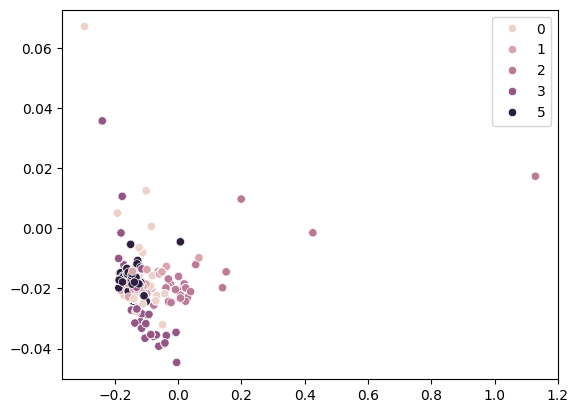

In [57]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
we_reduced = pca.fit_transform(weighted_embeddings)

sns.scatterplot(x=we_reduced[:, 0], y=we_reduced[:, 1], hue=symbols)

In [33]:
we_reduced.shape

(11614, 2)

In [34]:
we_reduced

array([[-0.31708452,  0.06350003],
       [-0.07229727, -0.01773336],
       [ 0.17836064,  0.00797884],
       ...,
       [ 0.04478328, -0.01205951],
       [-0.06294624, -0.02444027],
       [-0.07971334, -0.01774998]])

<Axes: >

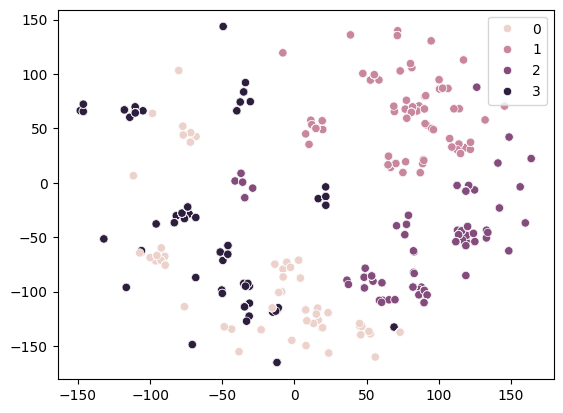

In [53]:
from sklearn.manifold import TSNE

tsne = TSNE()
we_reduced = tsne.fit_transform(src_embeddings)

sns.scatterplot(x=we_reduced[:, 0], y=we_reduced[:, 1], hue=symbols)

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(4)
pred = kmeans.fit_predict(weighted_embeddings)

pred[:4]

/home/robert/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 0, 2, 0], dtype=int32)

In [37]:
np.where(pred==0)[:5]

(array([    1,     3,     4, ..., 11611, 11612, 11613]),)

In [38]:
np.unique(symbols[np.where(pred==0)], return_counts=True), 

((array([0, 1, 2, 3]), array([1433, 2946,  672, 1263])),)

In [39]:
np.unique(symbols[np.where(pred==2)], return_counts=True)

(array([2]), array([1207]))

In [40]:
np.unique(symbols[np.where(pred==3)], return_counts=True)

(array([0, 1, 3]), array([1514,    1, 1597]))

In [54]:
src_embeddings[np.where(symbols==1)]

array([[ 0.5971018 , -1.1054437 , -0.8227273 ],
       [ 0.5971018 , -1.1054437 , -0.8227273 ],
       [ 0.57074517, -1.0104891 , -0.716194  ],
       ...,
       [ 1.0045307 , -2.0289958 , -1.5510913 ],
       [ 0.5971018 , -1.1054437 , -0.8227273 ],
       [ 0.57074517, -1.0104891 , -0.716194  ]], dtype=float32)

(34842,)